In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

import torchvision

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


seed = 123
np.random.seed(seed)

to_tensor = T.ToTensor()
to_pil = T.ToPILImage()

norm = T.Lambda(lambda x: 2 * x - 1)
denorm = T.Lambda(lambda x: (x + 1) / 2)

In [3]:
from dataset_generator import showImagesHorizontally
from train_dyn_p0_v2 import VQVAE, generate_random_image, generate_params
from train_orig_v2 import VQVAE as VQVAE2

In [4]:
import os
from PIL import Image

def construct_run_name(codebook_size, num_codebooks, region_size, p0):
    run_name = f'train_orig_cs{codebook_size}'
    if num_codebooks > 1:
        run_name += f'_nc{num_codebooks}'
    if p0 is not None:
        run_name += f'_{p0}'
    if region_size is not None:
        run_name += f'_{region_size}'
    return run_name


def read_samples(root, epoch=None):
    if epoch is None:
        files = sorted(os.listdir(root))
        path = os.path.join(root, files[-1])
        return Image.open(path).convert('RGB')
    file = f'epoch_{str(epoch).zfill(4)}.png'
    path = os.path.join(root, files[-1])
    return Image.open(path.convert('RGB'))


def read_snapshot(root):
    snapshot_path = os.path.join(root, 'snapshot.tar')
    snapshot = torch.load(snapshot_path, map_location='cpu')
    return snapshot


def plot_metrics(metrics, root=None):
    if root is not None:
        snapshot = read_snapshot(root)
        metrics = snapshot['metrics']
    fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(20, 4))
    for (key, value), axis in zip(metrics.items(), axes):
        axis.plot(value)
        axis.grid()
        axis.set_xlabel('epoch')
        axis.set_ylabel(key)
        axis.set_title(f'{key} over epochs')

        
def build_model(snapshot):
    model_params = snapshot['model_params']
    state_dict = snapshot['model']
    if 'num_codebooks' not in model_params:
        model = VQVAE2(**model_params).eval()
    else:
        model = VQVAE(**model_params).eval()
    model.load_state_dict(state_dict)
    for p in model.parameters():
        p.requires_grad = False
    return model


def get_images(n):
    images = [generate_random_image(**generate_params) for _ in range(n)]
    images = [norm(to_tensor(image)) for image in images]
    images = torch.stack(images)
    return images

    
def infer_model(model, images):
    z = model.encoder(images)
    
#     shape = z.size(0), model.quantizer.num_codebooks, model.quantizer.n_embed, z.size(-2), z.size(-1)
    
    logits = model.quantizer.proj(z).view(z.size(0), -1, model.quantizer.n_embed, z.size(-2), z.size(-1))
    codes = F.gumbel_softmax(logits, tau=1, hard=True, dim=-3)
    
    soft_one_hot = codes.clone().view(z.size(0), -1, z.size(-2), z.size(-1))
    z_q = torch.einsum('b n h w, n d -> b d h w', soft_one_hot, model.quantizer.embed.weight)
    images_recon = model.decoder(z_q)
    
    n_selected = torch.sum(codes.argmax(dim=-3) != 0, dim=1)
    
    return images_recon, codes, n_selected


def create_grid(images, images_recon):
    grid = torch.cat([images, images_recon], dim=0)
    grid = torchvision.utils.make_grid(grid, nrow=images.size(0))
    grid = to_pil(denorm(grid))
    return grid

**Посмотрим на результаты обучения модели на отложенных картинках**

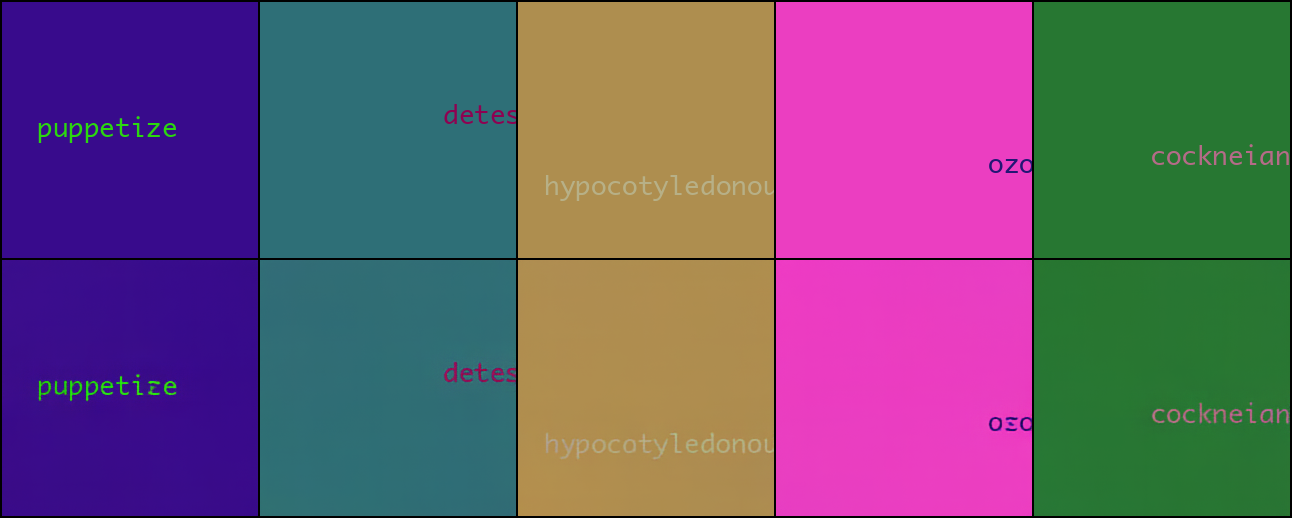

In [5]:
codebook_size = 64
num_codebooks = 40

# region_size = None
region_size = '16x16'

# p0 = None
p0 = 'p0'
# p0 = 'p08'

epoch = None
# epoch = 500

run_name = construct_run_name(codebook_size, num_codebooks, region_size, p0)

samples_root = 'samples'
samples_run_root = os.path.join(samples_root, run_name)

samples = read_samples(samples_run_root, epoch=epoch)
samples

**Загрузим модель, сгенерируем картинки, прогоним модель и посмотрим результат реконструкции**

In [6]:
snapshots_root = 'snapshots'
snapshots_run_root = os.path.join(snapshots_root, run_name)
snapshot = read_snapshot(snapshots_run_root)

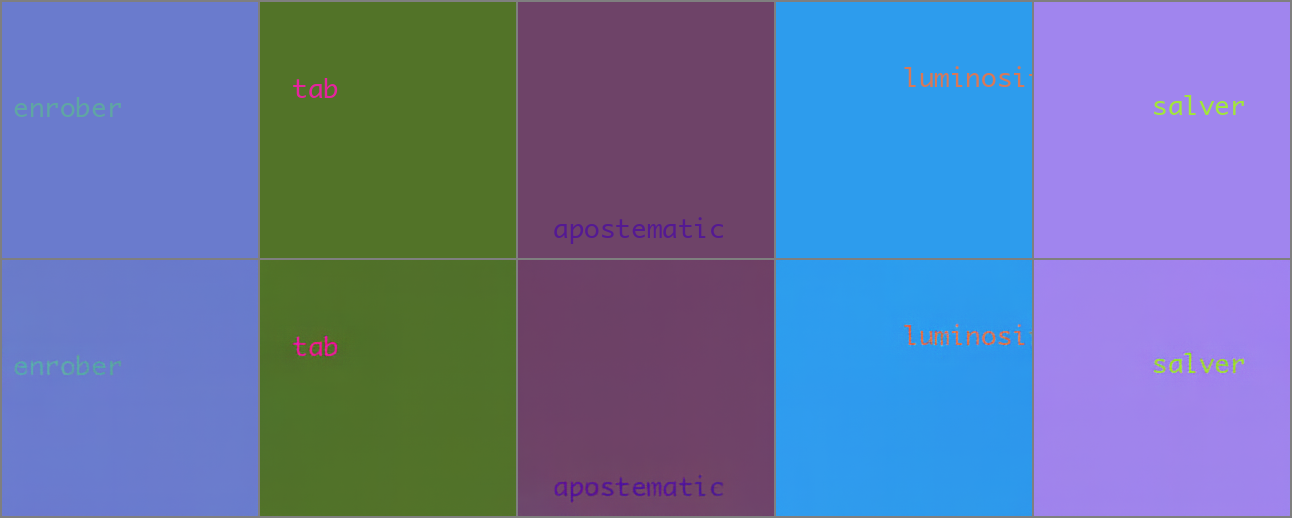

In [7]:
n_images = 5

model = build_model(snapshot)
images = get_images(n_images)
images_recon, codes, n_selected = infer_model(model, images)
create_grid(images, images_recon)

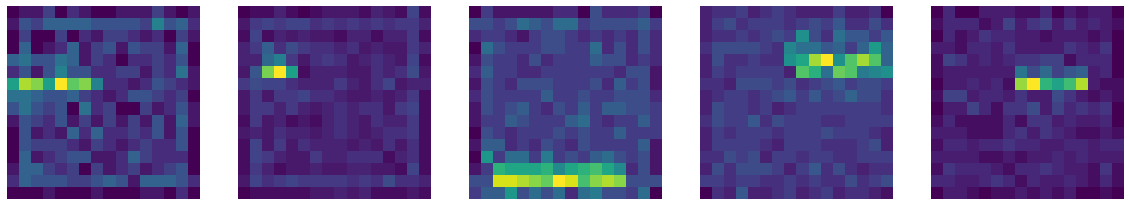

In [8]:
showImagesHorizontally(n_selected, figsize=(20, 20))

**Картинка сверху - количество выбранных моделью ненулевых кодов в каждом регионе**

**Посмотрим, сколько должно было быть кодов в регионе, сколько получилось. То же самое с длиной последовательности**

In [9]:
print('Mean number of selected codes per region')
print('actual:', torch.mean(n_selected.float(), dim=(1, 2)).mean().item())
print('expected:', 0.1 * num_codebooks)

print('\nLength of sequence')
print('actual:', torch.mean(n_selected.float().sum(dim=(1, 2))).item())
print('expected:', 0.1 * num_codebooks * n_selected.size(-2) * n_selected.size(-1))
print('No dyn. density:', 1024)

Mean number of selected codes per region
actual: 3.9140625
expected: 4.0

Length of sequence
actual: 1002.0
expected: 1024.0
No dyn. density: 1024
